# All Aboard the Karachi Load-Shedding Blame Train

## Overview

In this project, we are investigating whether or not we can predict if Karachi Electric will be blamed for load-shedding in Karachi, Pakistan based on tweets also blaming other entities for load-shedding in Karachi, Pakistan.  Ideally, we would find a model that will outperform a simple ratio of tweets blaming Karachi Electric to the total blames in the dataset.  If this fails, then we will simply choose the best model.  The performance metrics used will be the test score from a five-fold cross validation.  

Using social media to determine who is being blamed for load shedding in Karachi, Pakistan has been done on a small scale in the past:

https://www.linkedin.com/pulse/curious-case-k-electric-jamat-e-islami-karachites-aamir-abbasi-cipr-/

This project could be used by public relations officials or political entities to determine who is being blamed for load-shedding in Karachi, Pakistan.  Additionally, the data could be used to determine the severity of the load-shedding situation in Karachi, Pakistan.

You can see the notebooks for a step by step breakdown of the logic in the code.  In this notebook, I will present a broader view of the analysis.  In the first section of this notebook, we will cover how to get the data.  The second section involves the exploratory data analysis required to full understand the data.  In the third section, we cover the data preparation portion of the analysis.  In the fourth section, we cover the reasoning behind the models that we have chosen for the analysis.  The fifth section covers the details behind the models themselves.  The sixth section covers the fine-tuning we did to make the models the best they could be.  The seventh section will include visualizations of the chosen model's performance.  Finally, in the eighth section, we will discuss the limitations of the analysis and later work that can be done.

An interesting observation is that the entities I have found did not have normally distributed blames, so I had to drop some of the entities to normalize the data.  Also comparing an earlier search to a new search revealed anomalies in how the entities have been blamed through the timeframe of the project.

## 1. Get the Data

The data in this project comes from the Twitter API.  I used the twitter-python wrapper for the Twitter API to get it to work in python.  Please see the python-twitter [documentation](https://python-twitter.readthedocs.io/en/latest/index.html) for details on how to use the search functions.  The searches conducted were based on a manual scan of how people were blaming various entities for load-shedding in Karachi, Pakistan done at random points between mid-September and late November of 2020.  The dataset before cleaning included 8 rows and 74 columns.  The rows consisted of the following blamed entities:

Karachi Electric - A primary provider of electricity for Karachi, Pakistan.
Imran Khan - Current prime minister of Pakistan and leader of Tehreeki Insaaf.
Asad Umar - Tehreeki Insaaf Federal Minister for Planning, Development, Reforms, and Special Initiatives
NEPRA - The National Electric Power Regulatory Authority, responsible for regulating electricity in Pakistan.
Sui Gas - A Karachi-based natural gas provider, supplying many parts of Pakistan with natural gas.
Naeem Rehman - Leader of Jamaat-e Islami, Karachi
Omar Ayub Khan - Pakistan's Federal Minister for Energy
Tehreeki Insaaf - Pakistan's current political party in power 

The most important row in this case is Karachi Electric, because it is the entity which received the most blames and therefore, becomes the dependent variable for the models.  The columns were different tweeters who blamed one of the entities in the rows.

The searches had maxed-out parameters for what the Twitter API allows.  See the Limitations and Later Work section for more details.  Upon retrieving the searches, I took the twitter user names for all of the searches and put them all into sets to ensure there would be no duplicate user names in the data.  After this, I created dictionaries out of membership tests, assigning True or False based on whether or not the tweeter was blaming the person or organization.    

## 2. Explore the Data

In [7]:
from KLS_Data import kls_df
kls_df.T.head()

Blamed,Karachi Electric,Imran Khan,Asad Umar,NEPRA,Sui Gas,Naeem Rehman,Omar Ayub Khan,Tehreeki Insaaf
Tweeter0,1,0,0,1,0,0,0,1
Tweeter1,1,0,0,1,0,0,0,1
Tweeter2,1,0,0,1,0,0,0,1
Tweeter3,1,0,0,1,0,0,0,1
Tweeter4,1,0,0,1,0,0,0,1


In [2]:
print('The data has', kls_df.shape[0], 'rows and', kls_df.shape[1], 'columns.')

The data has 8 rows and 74 columns.


There was no inconsistency in the data types and no null values in the data.  There were some significant differences between the times the people were blamed relative to the organizations.  Clearly the people were not big enough targets to blame.  

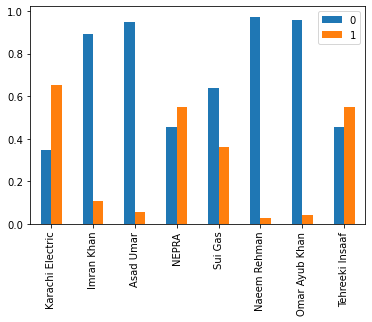

There were some anomalies in the overall percentage of blames relative to the percentages in a new search's blames.  All organizations in the dataset saw a higher percentage of the blames in the new search with the exception of Sui Gas.  This can probably be explained by a large rally against load-shedding that the initial search was able to reflect.  

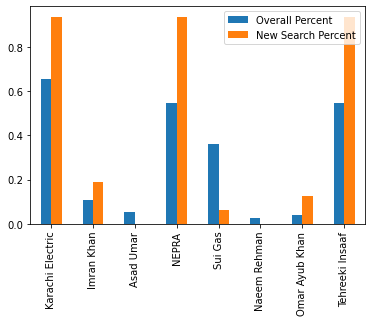

The data was not normalized.

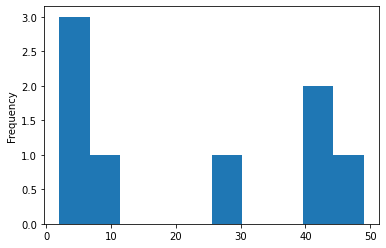

I took 10 random samples to see the disparity in blamed versus not-blamed in the data.  This showed there were signifantly more tweeters who did not blame many other entities.

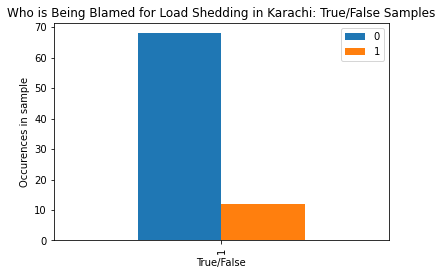

## 3. Prepare the Data

I turned the data from a list of dictionaries into a pandas DataFrame to better handle the data.  Here, I protected the privacy of the tweeters by giving them generic names.  I added previous searches from csv files to the new search to get more data into one dataset.  Because the data was not normalized, I decided to see if removing the entities that less than 25% of the tweeters were blaming.  This actually made the data much more normalized.  

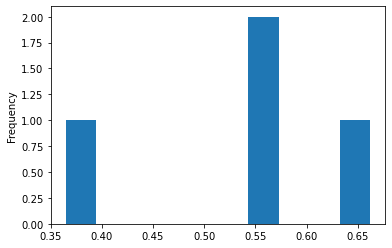

In [6]:
from KLS_EDA import blamed_percent

blamed_percent.drop(blamed_percent[blamed_percent['Overall Percent']\
                                   < 0.25].index, inplace = True)
blamed_percent['Overall Percent'].plot.hist()

I explicitly dropped the people from the DataFrame after determining they did not receive enough blames to include in the dataset.  Another way to do this would have been to use the code in blamed_percent to take out all of entitites that received less than 25% of the blames.  For the purposes of this project, I saw that those were the entities that I wanted to drop and explicitly dropped them.  Finally, to prepare the data for training, I turned the x variables and the y variable into two separate numpy arrays to reshape them.

## 4. Modeling

The question we are trying to answer is if we can predict if Karachi Electric (the entity with the most blames in the dataset) will be blamed based on the blames of other entities by the same tweeter.  This is a classification problem, so I chose exclusively classification models.  In particular, I chose Logistic Regression, Decision Tree Classification, and Random Forest Classification.  It was a little challenging with the latter two because this was my first exposure to either one.  Luckily, it couldn't have been easier with sci-kit learn's documentation and some quick googling about best practices.  To measure the accuracy of the models, I compared their mean test scores in a five fold cross-validation.  The baseline I chose is the ratio of Karachi Electric blames to the number of people blaming anyone because it should give a rough example of what to expect with the number of Karachi Electric's blames. 

For all of the models, I used the same train_test_split function from sci-kit learn with a random state of 1 and adjusted all of the models' random states to 1.  I initially thought that Random Forest must be the best model because it has the most moving parts to tweak; however, in a close contest, logistic regression was the best performing model. 

## 6. Fine Tune

To fine-tune the logistic regression model, I attempted applying an l2 penalty to the model, but this reduced the model's mean test score in the five fold cross-validation, so the original model that I trained which contained no penalty was the better performing model, although both of the models' standard deviations were within the margin of error.  Some very interesting insights came from the decision tree fine-tuning.  The decision tree model's mean test score responded positively upon adjusting the model's class weight parameter to focus more on True values than the False values.  Interestingly, the random forest model did not respond to adjusting the class weight parameters like the decision tree model did.  What did make a difference was adjusting the n_estimators parameter from 10 to 50, which decreased the model's standard deviation, but did not effect the mean test score.  Any higher than 50 n_estimators showed no difference for the model's test score nor its standard deviation.    

## 7. Present Your Solution

Below are the highest mean test scores for each model trained in the project. The brackets represent the model's standard deviation:

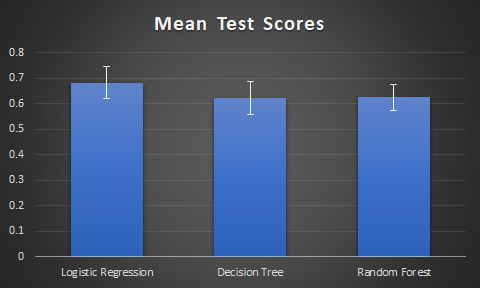

As we can see, the Logistic Regression model achieved the highest test scores out of the models trained in the project.  Below are some probabilities that the logistic regression model has concluded:

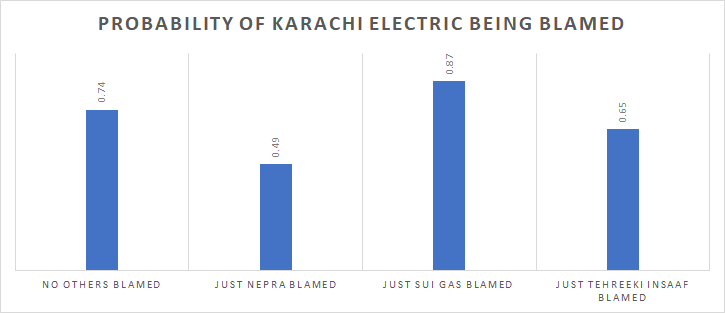

Additionally, the logistic regression model's mean test score of 0.68 beat the dummy model's score of 0.67, achieving the goal of this project.  Worth noting is all of the mean test scores were within the margin of error.

## 8. Limitations and Later Work

Though I didn't run into this issue during the project, the Twitter API only allows for 100 tweet pulls per search, which limits the amount of data we can add to the dataset.  The most challenging issue with the Twitter API is that it only allows for searches from the past seven days, so there was no way of pulling historical data.  Although these most recent models were more accurate than previous models that I tested in earlier versions of the project, I am not satisfied with the accuracy of any of the models tested as part of a practical measure of whether or not Karachi Electric will be blamed.  Continued work on this project could revolve around finding other variables that we could add to models.  The project can also be pulled apart and tweaked to use for other public relations or political applications based on who is being blamed for different issues. 